In [45]:
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv("data/RickAndMortyScripts.csv")
df.head()

,index,season no.,episode no.,episode name,name,line
0,0,1,1,Pilot,Rick,Morty! You gotta come on. Jus'... you gotta co...
1,1,1,1,Pilot,Morty,"What, Rick? What’s going on?"
2,2,1,1,Pilot,Rick,"I got a surprise for you, Morty."
3,3,1,1,Pilot,Morty,It's the middle of the night. What are you tal...
4,4,1,1,Pilot,Rick,"Come on, I got a surprise for you. Come on, h..."


In [18]:
df.describe()

,index,season no.,episode no.
count,1905.000000,1905.000000,1905.000000
mean,1190.003675,2.155381,3.208399
std,721.719735,0.832004,2.247812
min,0.000000,1.000000,1.000000
25%,548.000000,1.000000,1.000000
50%,1164.000000,2.000000,3.000000
75%,1844.000000,3.000000,5.000000
max,2487.000000,3.000000,10.000000


In [19]:
df.nunique()

index           1905
season no.         3
episode no.        9
episode name      11
name              48
line            1860
dtype: int64

In [20]:
df.count()

index           1905
season no.      1905
episode no.     1905
episode name    1905
name            1905
line            1905
dtype: int64

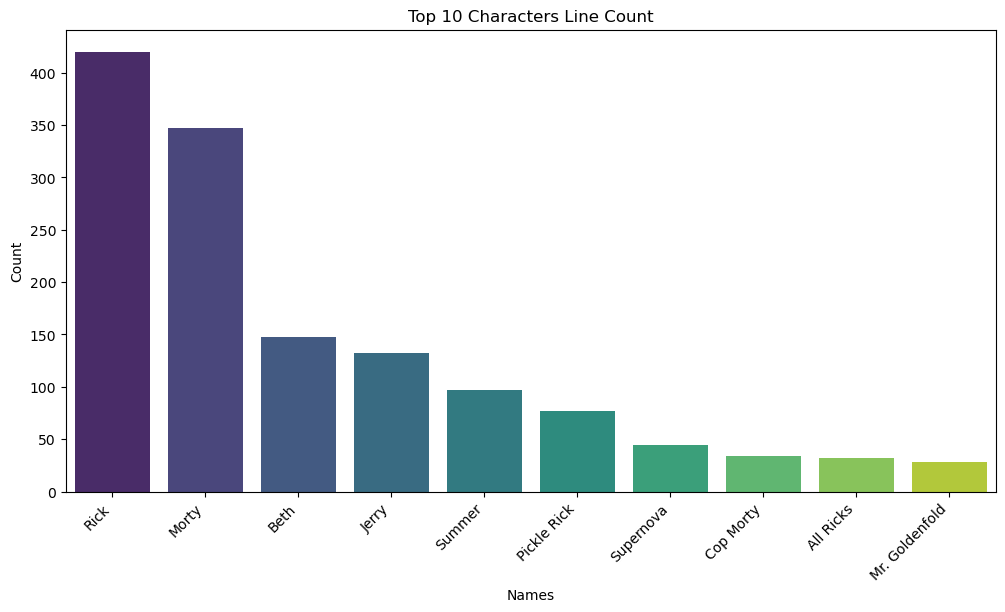

In [28]:
top_names = df['name'].value_counts().nlargest(10).index

filtered_data = df[df['name'].isin(top_names)]

plt.figure(figsize=(12, 6))  
ax = sns.countplot(data=filtered_data, x='name', order=top_names, palette='viridis')

ax.set(xlabel='Names', ylabel='Count', title='Top 10 Characters Line Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

In [46]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions

sw = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in sw])

tokenizer = TweetTokenizer()

df['line'] = df['line'].apply(lambda text: remove_stopwords(text))
df['line'] = df['line'].apply(lambda text: contractions.fix(text))
df['line'] = df['line'].str.lower()
df['line'] = df['line'].str.replace(r"http\S+", " ", regex=True)
df['line'] = df['line'].str.replace(r'\d+', '')
df['line'] = df['line'].str.replace('[^A-Za-z0-9]+', ' ', regex=True)
df['line'] = df['line'].apply(lambda text: ' '.join(tokenizer.tokenize(text)))
df['line'] = df['line'].apply(lambda text: remove_stopwords(text))
df['line'] = df['line'].str.strip()

df['line'].head(10)

0                          morty got come jus got come
1                                           rick going
2                                   got surprise morty
3                                 middle night talking
4                         come got surprise come hurry
5                                   ow ow tugging hard
6         got go got get outta come got surprise morty
7    think flying vehicle morty built outta stuff f...
8                             yeah rick great surprise
9                    morty make bomb morty create bomb
Name: line, dtype: object

In [67]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df['line'] = df['line'].astype(str) 
df

from itertools import product
top_names = ['Rick','Morty','Beth','Jerry','Pickle Rick']
                                                                                                                                
tokenizer = TweetTokenizer()
df['tokens'] = df['line'].apply(lambda text: tokenizer.tokenize(text))


new_df = pd.DataFrame(list(product(df['name'], df['tokens'].explode())), columns=['name', 'word'])
new_df = new_df[new_df['name'].isin(top_names)]
new_df
new_df['sentiment_score'] = new_df['word'][:100].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
new_df.head(50)
# positive_df = new_df[new_df['sentiment_score'] > 0.1]
# negative_df = new_df[new_df['sentiment_score'] <= -0.1]

# def generate_word_cloud(text, title):
#     wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
#     plt.figure(figsize=(10, 5))
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis('off')
#     plt.title(title)
#     plt.show()

# positive_text = ' '.join(positive_df['line'])
# negative_text = ' '.join(negative_df['line'])

# generate_word_cloud(positive_text, 'Positive Words')
# generate_word_cloud(negative_text, 'Negative Words')


,name,word,sentiment_score
0,Rick,morty,0.000000
1,Rick,got,0.000000
2,Rick,come,0.000000
3,Rick,jus,0.000000
4,Rick,got,0.000000
5,Rick,come,0.000000
6,Rick,rick,0.000000
7,Rick,going,0.000000
8,Rick,got,0.000000
9,Rick,surprise,0.000000
